### Deep Learning by Dr Mohsin Ali at ITU
### Assignment 05 - Part 2
### Covid-19 Dataset




### Importing Libraries

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from IPython.display import clear_output # for clearing the output of a cell

% matplotlib inline

### Loading Dataset

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip -uq '/content/gdrive/My Drive/Asg5/A_05_Part_02_Dataset.zip'

# import zipfile

# zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Asg5/A_05_Part_02_Dataset.zip", 'r')
# zip_ref.extractall("/")
# zip_ref.close()

# !cp "A_05_Part_02_Dataset/*" "/content/gdrive/My Drive/Asg5/"

In [0]:
!ls A_05_Part_02_Dataset/Train/

covid-19  normal  pneumonia


In [0]:
data_dir = 'A_05_Part_02_Dataset'

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
# test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform=train_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
import cv2
import os
from PIL import Image

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_fnames = []

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        test_fnames.append(filename)
        img = cv2.imread(os.path.join(folder,filename))
        img = Image.fromarray(img)
        if img is not None:
            images.append(img)
    return images

test_data = load_images_from_folder('A_05_Part_02_Dataset/Test')
print(len(test_data))
# testset = CustomDataset(data, transform=test_transforms)
test_data = [test_transforms(i) for i in test_data]
print(len(test_data))

629
629


In [0]:
print(len(trainloader.dataset))
# print(len(testloader.dataset))
print(len(valloader.dataset))

6200
628


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        title = "Label: " + str(title)
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# # Get a batch of training data
# inputs, classes = next(iter(trainloader))
# show_databatch(inputs, classes)

### Load pre-trained VGG-16

In [0]:
# Load the pretrained model from pytorch
# vgg16 = models.vgg16(pretrained=True)

# for resnet
vgg16 = models.resnet18(pretrained=True)

print(vgg16)
# print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# print(vgg16.classifier[3])

### Freezing the layers (All Convolution Layers)

In [0]:
# # Freezing training for all convolution layers
# for param in vgg16.features[0:-10].parameters(): # last convolution is not set to not train 
#     param.requires_grad = False

In [0]:
# i = 0
# for param in vgg16.features.parameters(): # last convolution is not set to not train 
#     i += 1
#     print(i," ",param.requires_grad)

### Making 2 FC Layer to be replaced in the VGG16

In [0]:
# num_features = vgg16.classifier[0].in_features # getting the input features from the VGG16 in Fc layers
# features = list([nn.Linear(num_features, 470)]) # my rollnumber = (37x10) + 100 = 470
# features.extend([nn.Linear(470, 3)])#len(class_names))])
# features.extend([nn.Sigmoid()])

# num_features = vgg16.classifier[6].in_features
# features = list(vgg16.classifier.children())[:-1] # Remove last layer
# features.extend([nn.Linear(num_features, len(class_names))])
# features.extend([nn.Sigmoid()])


# for resnet
num_features = vgg16.fc.in_features # getting the input features from the VGG16 in Fc layers
features = list([nn.Linear(num_features, 470)]) # my rollnumber = (37x10) + 100 = 470
features.extend([nn.Linear(470, len(class_names))])

print(features)

[Linear(in_features=512, out_features=470, bias=True), Linear(in_features=470, out_features=3, bias=True)]


In [0]:
# features.extend([nn.Linear(num_features, len(class_names))])

In [0]:
# vgg16.classifier = nn.Sequential(*features)

# for resnet
vgg16.fc = nn.Sequential(*features)

print(vgg16)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Code for Focal Loss

In [0]:
# class FocalLoss(nn.Module):
#     def __init__(self,gamma=2): # choosen gamma as 2
#         super(FocalLoss, self).__init__()
#         self.gamma = gamma
        
#     def forward(self, inputs, targets):
#         loss_bce = nn.BCEWithLogitsLoss(inputs, targets)
#         p_t = torch.exp(-loss_bce)
#         loss_focal = torch.mul(torch.pow((1-p_t), self.gamma), loss_bce)
#         return torch.mean(loss_focal)

def focalLoss(outputs, targets):
    gamma = 5
    loss_bce = nn.BCEWithLogitsLoss()(outputs, targets)
    p_t = torch.exp(-loss_bce)
    loss_focal = torch.mul(torch.pow((1-p_t), gamma), loss_bce)
    # return torch.mean(loss_focal)
    return loss_focal

### Loss function and optimizer

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()#CrossEntropyLoss()
# criterion = focalLoss()#CrossEntropyLoss()

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

### Function for finding accuracy

In [0]:
from sklearn.metrics import confusion_matrix # for plotting confusuion matrix
from sklearn.metrics import f1_score # for finding f1 score

In [0]:
def get_accuracy(my_loader):
  correct = 0
  total = 0
  all_preds = list() # for saving all predictions
  orig_labels = list()
  with torch.no_grad():
      for data in my_loader:
          images, labels = data
          labels = getOnehot(labels)
          images, labels = images.to(device), labels.to(device)
          outputs = vgg16(images)
          predicted = torch.sigmoid(outputs.data)
          # _, predicted = torch.max(outputs.data, 1)
          predicted = getMyPreds(predicted)

          all_preds.extend(predicted) # extending for predicted labels
          orig_labels.extend(labels) # extending for predicted labels

          total += labels.size(0)
          correct += (torch.all(torch.eq(predicted, labels),1)).sum().item()
  return 100 * (correct/total), orig_labels, all_preds

In [0]:
def getOnehot(labels):
  onehot = []
  for label in labels:
    if label == 0 : # for covid
      onehot.append([1, 1, 0])
    elif label == 2 : # for pneumonia
      onehot.append([0, 1, 0])
    elif label == 1 : # for normal
      onehot.append([0, 0, 1])
  return torch.Tensor(onehot)

In [0]:
def getMyPreds(la):
  labels = la
  onehot = []
  for label in labels:
    sub =[]
    for lab in label:
      if lab>0.5:
        sub.append(1)
      else:
        sub.append(0)
    onehot.append(sub)
  return torch.Tensor(onehot).to(device)

### Training

In [0]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

train_loss = []
train_acc = []

val_loss = []
val_acc = []


for epoch in range(Epochs):
  for part in ["training", "validation"]: # as every epoch has training and validation

    curr_loader =[] # current loading for storing the training and validation
    if part == "training":
      vgg16.train(True) # training is true for training data
      curr_loader = trainloader
      
    else:
      vgg16.train(False) # training is false for validation data
      curr_loader = valloader

    running_loss = 0.0 # for running loss
    running_acc = 0 # for running accuracy

    pbar = tqdm(enumerate(curr_loader)) # loading training data
    for i, data in pbar:
        # getting input
        inputs, labels = data
        # print(labels)
        labels = getOnehot(labels)
        # print(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()# zeroing the gradient

        outputs = vgg16(inputs)  
        loss = criterion(outputs, labels)
        # loss = focalLoss(outputs, labels)

        if part == "training": # no learning from validation data
          loss.backward() 
          optimizer.step()
        # print(outputs.data)
        # _, preds = torch.max(outputs.data, 1)
        preds = torch.sigmoid(outputs.data)

        # print statistics
        running_loss += loss.item()
        # print(preds)
        # print(labels)
        preds = getMyPreds(preds)
        # running_acc += torch.sum(preds == labels)
        running_acc += (torch.all(torch.eq(preds, labels),1)).sum().item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(curr_loader.dataset),
                100. * i / len(curr_loader),
                loss.data))
        
    # clear_output()
    if part == "training": # storing for training
      train_loss.append(running_loss)
      train_acc.append(running_acc)
    else: # storing for validation
      val_loss.append(running_loss)
      val_acc.append(running_acc)
    # print(running_loss)
    print(running_acc)

    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')

Train Epoch: 0 [4632/6200 (99%)]	Loss: 0.281329: : 194it [02:19,  1.39it/s]
0it [00:00, ?it/s]

4561


Train Epoch: 0 [380/628 (95%)]	Loss: 0.304199: : 20it [00:13,  1.50it/s]
0it [00:00, ?it/s]

527


Train Epoch: 1 [4632/6200 (99%)]	Loss: 0.146699: : 194it [02:20,  1.38it/s]
0it [00:00, ?it/s]

5222


Train Epoch: 1 [380/628 (95%)]	Loss: 0.309034: : 20it [00:13,  1.50it/s]
0it [00:00, ?it/s]

537


Train Epoch: 2 [4632/6200 (99%)]	Loss: 0.312330: : 194it [02:19,  1.39it/s]
0it [00:00, ?it/s]

5317


Train Epoch: 2 [380/628 (95%)]	Loss: 0.144807: : 20it [00:13,  1.50it/s]
0it [00:00, ?it/s]

545


Train Epoch: 3 [4632/6200 (99%)]	Loss: 0.171743: : 194it [02:19,  1.39it/s]
0it [00:00, ?it/s]

5375


Train Epoch: 3 [380/628 (95%)]	Loss: 0.168019: : 20it [00:13,  1.52it/s]
0it [00:00, ?it/s]

553


Train Epoch: 4 [4632/6200 (99%)]	Loss: 0.158548: : 194it [02:19,  1.39it/s]
0it [00:00, ?it/s]

5386


Train Epoch: 4 [380/628 (95%)]	Loss: 0.128871: : 20it [00:13,  1.49it/s]
0it [00:00, ?it/s]

547


Train Epoch: 5 [4632/6200 (99%)]	Loss: 0.082565: : 194it [02:19,  1.39it/s]
0it [00:00, ?it/s]

5447


Train Epoch: 5 [380/628 (95%)]	Loss: 0.129551: : 20it [00:13,  1.50it/s]
0it [00:00, ?it/s]

547


Train Epoch: 6 [4632/6200 (99%)]	Loss: 0.263729: : 194it [02:18,  1.40it/s]
0it [00:00, ?it/s]

5454


Train Epoch: 6 [380/628 (95%)]	Loss: 0.180319: : 20it [00:13,  1.50it/s]
0it [00:00, ?it/s]

564


Train Epoch: 7 [4632/6200 (99%)]	Loss: 0.213052: : 194it [02:18,  1.40it/s]
0it [00:00, ?it/s]

5495


Train Epoch: 7 [380/628 (95%)]	Loss: 0.309354: : 20it [00:13,  1.47it/s]
0it [00:00, ?it/s]

564


Train Epoch: 8 [4632/6200 (99%)]	Loss: 0.331609: : 194it [02:20,  1.38it/s]
0it [00:00, ?it/s]

5540


Train Epoch: 8 [380/628 (95%)]	Loss: 0.150340: : 20it [00:13,  1.49it/s]
0it [00:00, ?it/s]

567


Train Epoch: 9 [4632/6200 (99%)]	Loss: 0.163087: : 194it [02:19,  1.39it/s]
0it [00:00, ?it/s]

5523


Train Epoch: 9 [380/628 (95%)]	Loss: 0.061696: : 20it [00:13,  1.51it/s]

561
Finished Training


In [0]:
# a = [1,2,1]
# a=getOnehot(a)
# b = [1,2,0]
# b=getOnehot(b)
# print(a)
# print(b)
# print(torch.all(torch.eq(a, b),1))
# print(torch.eq(a, b))

### Plotting the Curves

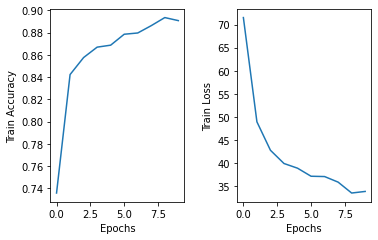

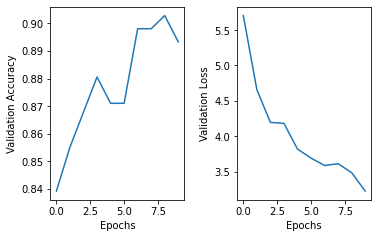

In [0]:
plt.subplot(121)
plt.tight_layout(pad=3.00)
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.plot(range(Epochs),np.asarray(train_acc)/len(trainloader.dataset))
plt.subplot(122)
plt.tight_layout(pad=3.00)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.plot(range(Epochs),train_loss)
plt.show()

plt.subplot(121)
plt.tight_layout(pad=3.00)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.plot(range(Epochs),np.asarray(val_acc)/len(valloader.dataset))
plt.subplot(122)
plt.tight_layout(pad=3.00)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.plot(range(Epochs),val_loss)
plt.show()

### Testing on Test Data and Plotting Confusion Matrix

In [0]:
# acc, my_orig, my_preds = get_accuracy(testloader)
# print("Accuracy on testing dataset is ", acc)

# my_orig = [int(i.cpu().numpy()) for i in my_orig]
# my_preds = [int(i.cpu().numpy()) for i in my_preds]

# print("F1 score for testing dataset is ", f1_score(my_orig, my_preds, average='binary'))

# cf_matrix = confusion_matrix(my_orig, my_preds)
# plt.imshow(cf_matrix)
# plt.title("Confusion Matrix For Testing Data")
# plt.colorbar()
# plt.show()

### Plotting Confusion Matrices for Training and Validation Data

In [0]:
from sklearn.metrics import multilabel_confusion_matrix

Accuracy on training dataset is  90.40322580645162
Confusion Matrix For Training Data
[[[5987   13]
  [ 124   76]]

 [[3849  151]
  [ 314 1886]]

 [[1883  317]
  [ 148 3852]]]


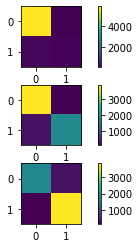

In [0]:
acc, my_orig, my_preds = get_accuracy(trainloader)
print("Accuracy on training dataset is ", acc)

my_orig = [i.cpu().numpy() for i in my_orig]
my_preds = [i.cpu().numpy() for i in my_preds]

cf_matrix = multilabel_confusion_matrix(my_orig, my_preds)
print("Confusion Matrix For Training Data")
print(cf_matrix)

plt.subplots_adjust(hspace=0.3,wspace = 0.4)
plt.subplot(311)
plt.imshow(cf_matrix[0])
plt.colorbar()

plt.subplot(312)
plt.imshow(cf_matrix[1])
plt.colorbar()

plt.subplot(313)
plt.imshow(cf_matrix[2])
plt.colorbar()
plt.show()

Accuracy on validation dataset is  91.0828025477707
Confusion Matrix For Validation Data
[[[596   4]
  [ 14  14]]

 [[390  10]
  [ 32 196]]

 [[196  32]
  [ 13 387]]]


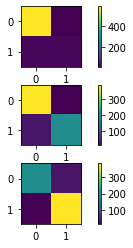

In [0]:
acc, my_orig, my_preds = get_accuracy(valloader)
print("Accuracy on validation dataset is ", acc)

my_orig = [i.cpu().numpy() for i in my_orig]
my_preds = [i.cpu().numpy() for i in my_preds]

# print("F1 score for validation dataset is ", f1_score(my_orig, my_preds,'binary'))

cf_matrix = multilabel_confusion_matrix(my_orig, my_preds)
print("Confusion Matrix For Validation Data")
print(cf_matrix)

plt.subplots_adjust(hspace=0.3,wspace = 0.4)
plt.subplot(311)
plt.imshow(cf_matrix[0])
plt.colorbar()

plt.subplot(312)
plt.imshow(cf_matrix[1])
plt.colorbar()

plt.subplot(313)
plt.imshow(cf_matrix[2])
plt.colorbar()
plt.show()

In [0]:
fname = "/content/gdrive/My Drive/saved_models_asg5/resnet18_entire_without_focal_loss"
fname2 = fname + ".pth"
torch.save(vgg16.state_dict(), fname2)

## Predicting Labels for Unlabelled data in Python

In [0]:
def pred_all(my_loader):
  all_preds = list() # for saving all predictions
  with torch.no_grad():
      for data in my_loader:
          images = data
          images = images.to(device)
          outputs = vgg16(images)
          predicted = torch.sigmoid(outputs.data)
          # _, predicted = torch.max(outputs.data, 1)
          predicted = getMyPreds(predicted)
          all_preds.extend(predicted) # extending for predicted labels

  return all_preds

In [0]:
# predicting labels for unknown test labels
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
my_preds = pred_all(testloader)
# my_preds = list(my_preds.cpu().numpy())

# making pandas dataframe
import pandas as pd  
   
imgName = test_fnames # file names saved above
covid = [i[0].cpu().numpy() for i in my_preds] # for covid
pneumonia = [i[1].cpu().numpy() for i in my_preds] # for pneumonia
normal = [i[2].cpu().numpy() for i in my_preds] # for normal
   
my_dict = {'Image Name': imgName, 'covid': covid, 'pneumonia': pneumonia, 'normal': normal}  

df = pd.DataFrame(my_dict)

fname2 = fname + ".csv"
df.to_csv(fname2) 

### Finding Best and Worst Classified Images

In [0]:
# # best is the one which will have the maximum probability of 1 in the correct place
# # worst is the one which will have the minimum probability of 1 in the wrong place
# def find_best(my_loader, l):
#   best = 0
#   best_label = 0
#   best_prob = 0
#   with torch.no_grad():
#       for data in my_loader:
#           images, labels = data
#           images, labels = images.to(device), labels.to(device)
#           outputs = vgg16(images)
#           _, predicted = torch.max(outputs.data, 1)
          
#           for i in range(0,len(predicted)):
#             if int(labels[i].cpu().numpy()) == l:
#               if predicted[i] == labels[i]: # if same
#                   if (outputs[i][labels[i]]>best_prob):
#                     best_prob = outputs[i][labels[i]]
#                     best = images[i]
#                     best_label = labels[i]

#   return best, best_label, best_prob

# print("Best Image for class 0")
# A = find_best(testloader, 0)
# # print("The correct label of this image had probability of ",A[2].cpu().numpy())
# imshow(A[0].cpu(),int(A[1].cpu()))

# print("Best Image for class 1")
# A = find_best(testloader, 1)
# # print("The correct label of this image had probability of ",A[2].cpu().numpy())
# imshow(A[0].cpu(),int(A[1].cpu()))

In [0]:
# def find_worst(my_loader,l):
#   worst = 0
#   worst_label = 0
#   worst_prob = 1
#   with torch.no_grad():
#       for data in my_loader:
#           images, labels = data
#           images, labels = images.to(device), labels.to(device)
#           outputs = vgg16(images)
#           _, predicted = torch.max(outputs.data, 1)
          
#           for i in range(0,len(predicted)):
#             if int(labels[i].cpu().numpy()) == l:
#               if predicted[i] != labels[i]: # if same
#                   if (outputs[i][labels[i]]<worst_prob):
#                     worst_prob = outputs[i][labels[i]]
#                     worst = images[i]
#                     worst_label = labels[i]
#   return worst, worst_label, worst_prob

# print("Worst Image for Class 0")
# A = find_worst(testloader,0)
# # print("The correct label of this image had probability of ",A[2])
# imshow(A[0].cpu(),int(A[1].cpu()))

# print("Worst Image for Class 1")
# A = find_worst(testloader,1)
# # print("The correct label of this image had probability of ",A[2])
# imshow(A[0].cpu(),int(A[1].cpu()))